In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob


def get_modified_KGE(obs,sim):
    sim[sim<0] = np.nan
    obs[obs<0] = np.nan
    ind = (~np.isnan(obs)) & (~np.isnan(sim))
    obs = obs[ind]
    sim = sim[ind]

    try:
        sd_sim=np.std(sim, ddof=1)
        sd_obs=np.std(obs, ddof=1)
        m_sim=np.mean(sim)
        m_obs=np.mean(obs)
        r=(np.corrcoef(sim,obs))[0,1]
        relvar=(float(sd_sim)/float(m_sim))/(float(sd_obs)/float(m_obs))
        bias=float(m_sim)/float(m_obs)
        kge=1.0-np.sqrt((r-1)**2 +(relvar-1)**2 + (bias-1)**2)
    except:
        kge = np.nan
    
    print(f'KGE:{kge},  r:{r},  relvar:{relvar},  bias:{bias}')
    
    return kge

In [8]:
# Basin 0
n = 0
ds_surf = xr.load_dataset('/glade/work/guoqiang/CTSM_cases/CAMELS_Calib/shared_data_Sean/surfdata_CAMELS_hist_78pfts_CMIP6_simyr2000_c221004.nc')
area = ds_surf.AREA.isel(gridcell=n).values

# priori
folder1st = glob.glob(f'/glade/work/guoqiang/CTSM_cases/CAMELS_Calib/Lump_calib/CAMELS_{n}_OstCalib/archive/PreserveModelOutput/*/')
folder1st.sort()
ds_simu_priori = xr.open_mfdataset(f'{folder1st[0]}/*clm2.h1*')
ds_simu_priori = ds_simu_priori[['QRUNOFF']].isel(lndgrid=n).load()
ds_simu_priori['time'] = ds_simu_priori.indexes['time'].to_datetimeindex()
ds_simu_priori['QRUNOFF'].values = (ds_simu_priori['QRUNOFF'].values / 1000) * (area * 1e6)

# calib
ds_simu_calib = xr.open_mfdataset(f'/glade/work/guoqiang/CTSM_cases/CAMELS_Calib/Lump_calib/CAMELS_{n}_OstCalib/archive/PreserveBestModel/*clm2.h1*')
ds_simu_calib = ds_simu_calib[['QRUNOFF']].isel(lndgrid=n).load()
ds_simu_calib['time'] = ds_simu_calib.indexes['time'].to_datetimeindex()
ds_simu_calib['QRUNOFF'].values = (ds_simu_calib['QRUNOFF'].values / 1000) * (area * 1e6)

# obs
df_obs = pd.read_csv(f'/glade/work/guoqiang/CTSM_cases/CAMELS_Calib/Lump_calib/CAMELS_{n}_OstCalib/refdata/streamflow_data.csv')
ds_obs = xr.Dataset()
ds_obs.coords['time'] = pd.to_datetime(df_obs['Date'].values)
ds_obs['Runoff_cms'] = xr.DataArray(df_obs['Runoff_cms'].values, dims=['time']) # flexible time

# same time
ds_obs = ds_obs.sel(time=ds_obs.time.isin(ds_simu_calib.time))
ds_simu_priori = ds_simu_priori.sel(time=ds_simu_priori.time.isin(ds_obs.time))
ds_simu_calib = ds_simu_calib.sel(time=ds_simu_calib.time.isin(ds_obs.time))



/glade/work/guoqiang/conda-envs/npl-2022b-tgq/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/glade/scratch/guoqiang/ipykernel_21174/1083998182.py:11: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  ds_simu_priori['time'] = ds_simu_priori.indexes['time'].to_datetimeindex()
/glade/work/guoqiang/conda-envs/npl-2022b-tgq/lib/python3.8/site-packages/xarray/coding/times.py:360: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/glade/scratch/guoqiang/ipykernel_21174/1083998182.py:17: RuntimeWarning: Converting a CFTimeIndex with dates from a non

In [9]:
# Print KGE'
print('Priori')
kge_priori = get_modified_KGE(ds_obs.Runoff_cms.values, ds_simu_priori.QRUNOFF.values)

print('\nCalib')
kge_calib = get_modified_KGE(ds_obs.Runoff_cms.values, ds_simu_calib.QRUNOFF.values)


Priori
KGE:0.204476853396249,  r:0.4430141670017315,  relvar:1.48412744336982,  bias:1.2970597199179987

Calib
KGE:0.5693836084661977,  r:0.5814003509454508,  relvar:1.0947681026120861,  bias:1.0349830987236162


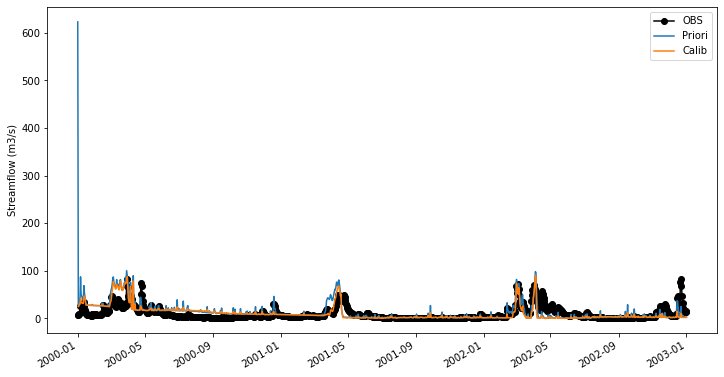

In [10]:
# Streamflow curves

fig, axs = plt.subplots(figsize=[12, 6])

ds_obs.Runoff_cms.plot(label='OBS', marker='o', color='k', linestyle=None)
ds_simu_priori.QRUNOFF.plot(label='Priori')
ds_simu_calib.QRUNOFF.plot(label='Calib')

plt.xlabel('')
plt.ylabel('Streamflow (m3/s)')

plt.legend()
plt.show()


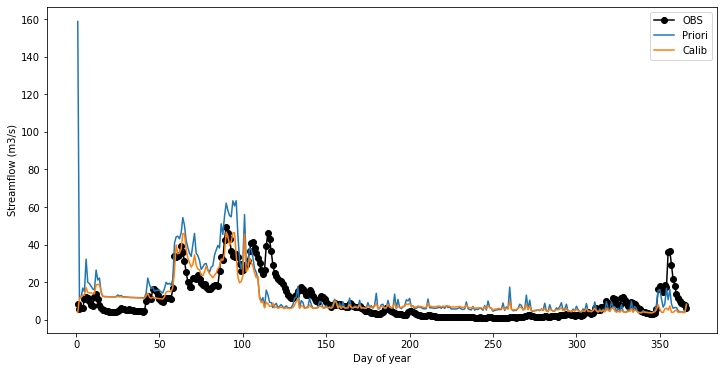

In [11]:
fig, axs = plt.subplots(figsize=[12, 6])

ds_obs.Runoff_cms.groupby("time.dayofyear").mean(dim='time').plot(label='OBS', marker='o', color='k', linestyle=None)
ds_simu_priori.groupby("time.dayofyear").mean(dim='time').QRUNOFF.plot(label='Priori')
ds_simu_calib.groupby("time.dayofyear").mean(dim='time').QRUNOFF.plot(label='Calib')

plt.xlabel('Day of year')
plt.ylabel('Streamflow (m3/s)')

plt.legend()
plt.show()

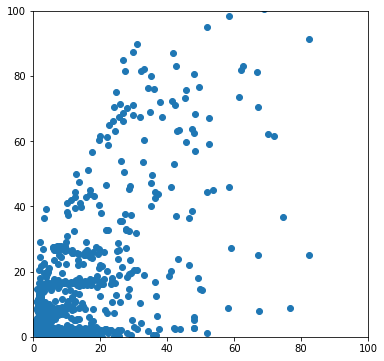

In [12]:
fig, axs = plt.subplots(figsize=[6, 6])

plt.scatter(ds_obs.Runoff_cms.values, ds_simu_priori.QRUNOFF.values)
plt.xlim(0, 100)
plt.ylim(0, 100)

plt.show()